<a href="https://colab.research.google.com/github/cliffaust/Cat-and-Dog-Classifier/blob/master/Malaria_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The problem we about to solve is that of the malaria cell detection. The main aim, is to use convolutional neural network(CNN), to identify if an input cell image is malaria or not.

This technic is best for image recognition in general. Image recognition is the process of giving the computer the ability to recognise input image. To describe what CNN is about, I would give a very simple example of what it's about.

![alt text](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

In the image above, an input image(which is an image of handwritten digit of number 2) of 28 x 28 x 1 (the 1 represents a grayscale image), is passed into a CNN model of (5x5) kernel shape, and a maxpooling of pool size (2x2) is done. This process is done twice, after which the image is flatten and passed into a Dense layer, after which some operations are done, and the output would be what the network thinks the input image is(This is a very simple and basic explation of what a CNN is about. You don't have to fully understand it).

In this tutorial, we are going to create a simple network to reognize a malaria cell. We would first import the necessary libraries;

If this is your first time working on image recognition, I would advice to check out tutorial 1, 2, 3 of this youtube video tutorial- https://www.youtube.com/watch?v=wQ8BIBpya2k&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&*index*=1

In [0]:
import numpy as np #for numeric computation of arrays
import matplotlib.pyplot as plt #for plotting
import os #for simply working on files and folder
import cv2 #for image preprocessing
from tensorflow.keras.models import Model #for funtional API models
from sklearn.model_selection import train_test_split #to split the datasets
from tensorflow.keras.utils import to_categorical #for converting the labels into one-hot-encode
from tensorflow.keras.utils import plot_model #for plotting the model achitecture
from tensorflow.keras.layers import Dense #for Dense layer network
from tensorflow.keras.layers import Flatten #for flatten image
from tensorflow.keras.layers import  Dropout #for turnnig off some of the nodes in a layer
from tensorflow.keras.layers import Conv2D #for a Convolutional layer
from tensorflow.keras.layers import AveragePooling2D #for performing a average pooling on the network 
from tensorflow.keras.layers import MaxPooling2D #for performing a maximum pooling layer
from tensorflow.keras.layers import concatenate #for adding two layer
from tensorflow.keras.layers import Input #for specifying the input shape
from tensorflow.keras.layers import Activation #for performing an activation on the layers
from tensorflow.keras.layers import BatchNormalization #for normalizing the input layer
from tensorflow.keras.regularizers import l1 #to reduce overfitting
from tensorflow.keras.optimizers import Adam #to apply optimization to the model

The datasets is from kaggle, with this link: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
I copied the API command by clicking on the option sign, next to the "New Notebook" button. 

The first cell below is just a code to install kaggle and create its directory(I got it from the kaggle website). The second cell below is to download the dataset to your working directory. The third cell is to unzip the zip folder. I also used a magic key(%%capture) in the third cell below to prevent it from displaying an output.

NOTE:you are suppose to download your kaggle api token and copy it to your working directory. Visi this github repo to know how to download kaggle API token and more: https://github.com/Kaggle/kaggle-api



In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 665M/675M [00:07<00:00, 47.2MB/s]
100% 675M/675M [00:07<00:00, 90.7MB/s]


In [0]:
%%capture
!unzip cell-images-for-detecting-malaria.zip

In [0]:
def get_dataset(size=60):
    datasets = []
    #get the names of the malaria group
    malaria_groups = []
    for name in os.listdir('cell_images'):
        malaria_groups.append(str(name))
    malaria_groups.remove('cell_images') # we are removing the cell_image
    #directory, because we dont need it in this tutorial

    #use the names to  get the images and place it in a list
    for malaria_group in malaria_groups:
        path = os.path.join('cell_images', malaria_group)
        index = malaria_groups.index(malaria_group)

        for image in os.listdir(path):
            try:
                images = cv2.imread(os.path.join(path, image))
                images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
                images = cv2.resize(images, (size, size))
                datasets.append([images, index])
            except:
                pass

    return datasets

In [0]:
#call the funtion to get the datasets
datasets = get_dataset()

In [0]:
#suffle the datasets
np.random.shuffle(datasets)

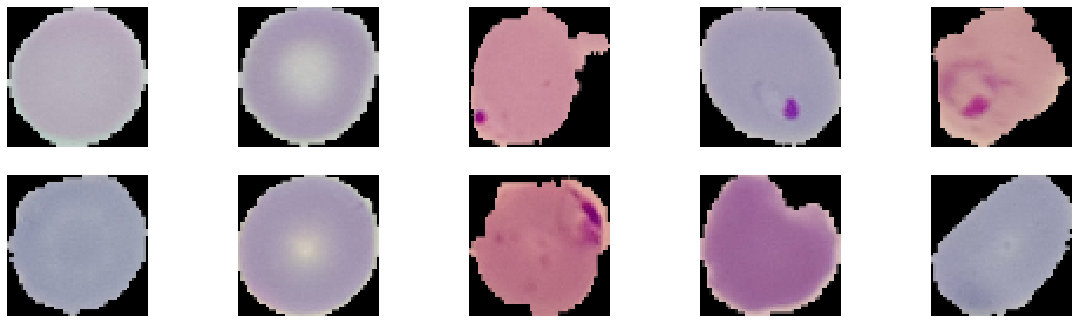

In [0]:
#display a sample of the images using matplotlib
n = 10

plt.figure(figsize=(20, 15))
for i in range(n):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(datasets[i][0])
    plt.axis('off')

plt.show()

The images and labels at this point are in the form of a list and are together. We have to first split it into two separate lists, then convert each of the list into an array, and reshaping the array.

Now to do computation fast and simple for the network, the images has to be scaled down into a range of 0 - 1. 

Lets write the code;

In [0]:
def preprocessing_datasets(datasets, num_labels):
    x = []
    y = []

    #categorize the train and test datasets(which contains both images and labels together in a list)
    for features, labels in datasets:
        x.append(features)
        y.append(labels)


    #convert both the train and test datasets into an array
    x = np.array(x).reshape(-1, 60, 60, 3) #the -1 is for the 
    #number of images, and the 60 is for the size, and the 3 is for the 
    #color channel(which is RGB)

    y = np.array(y).reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    #normalizing the image dataset
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    #one-hot-encode the labels
    y_train = to_categorical(y_train, num_labels)
    y_test = to_categorical(y_test, num_labels)

    return x_train, x_test, y_train, y_test

In [0]:
x_train, x_test, y_train, y_test = preprocessing_datasets(datasets, 2)

Our next step is to work on the model. We are going to use a cutom model. ):

In [0]:
#this model is called cliffNet
def cliffNet(height, width, depth, num_class):
    #we are going to create a conv module with batch normaliztion and activation
    #layer
    def conv_module(inputs, f, k, strides=(1,1), padding="same", 
                    kernel_initializer="he_uniform"):
        x = Conv2D(f, (k, k), strides=strides, padding=padding, 
                   kernel_initializer=kernel_initializer)(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    def inception_module(f1, f2, inputs):
        conv_1 = conv_module(inputs, f1, 3)
        conv_2 = conv_module(inputs, f2, 3)

        x = concatenate([conv_1, conv_2]) #we then add the two layers created
        return x

    def dropping(f, inputs):
        conv_3 = conv_module(inputs, f, 3, padding="valid", 
                             strides=(2,2))
        pool = MaxPooling2D(pool_size=(3,3), strides=(2,2))(inputs)

        x = concatenate([conv_3, pool])

        return x

    inputs = Input(shape=(height, width, depth))

    x = conv_module(inputs, 68, 3)

    x = inception_module(78, 90, x)
    x = inception_module(100, 120, x)
    x = dropping(65, x)

    x = inception_module(128, 145, x)
    x = inception_module(156, 168, x)
    x = AveragePooling2D(pool_size=(3,3))(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)
    x = Dense(215, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)

    x = Dense(num_class, activation="softmax")(x)

    model = Model(inputs, x)

    return model

In [0]:
model = cliffNet(60, 60, 3, 2)
opt = Adam(0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Lets take a look at the model achitecture

In [0]:
plot_model(model, show_shapes=True)

Time to train the model. ):

In [0]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=20, batch_size=120)

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 128s 6ms/sample - loss: 3.3121 - acc: 0.6209 - val_loss: 0.6588 - val_acc: 0.6299
Epoch 2/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.5738 - acc: 0.7150 - val_loss: 1.0661 - val_acc: 0.4987
Epoch 3/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.2818 - acc: 0.8977 - val_loss: 2.9143 - val_acc: 0.4989
Epoch 4/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.1783 - acc: 0.9383 - val_loss: 0.4448 - val_acc: 0.8095
Epoch 5/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.1472 - acc: 0.9500 - val_loss: 0.2005 - val_acc: 0.9307
Epoch 6/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.1390 - acc: 0.9522 - val_loss: 0.1532 - val_acc: 0.9492
Epoch 7/20
22046/22046 [==============================] - 112s 5ms/sample - loss: 0.1294 - acc: 0.9555 - val_lo

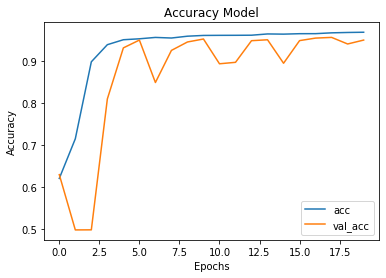

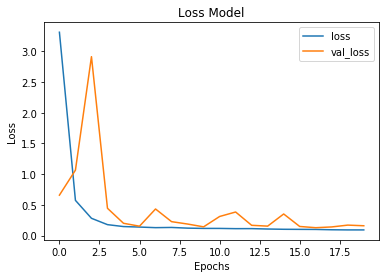

In [0]:
hist = hist.history

plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Model')
plt.legend(['acc', 'val_acc'])
plt.show()

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Model')
plt.legend(['loss', 'val_loss'])
plt.show()

we are able to achieve a train accuracy of over 96% and validation accuracy of over 94%. I think thats good for a model like this

Conclusion: CNN is a very good technic that is used in the field of image recognition. Having a good understanding of how it works would take you far in the field of artificial intelligence.

If you want to get a very grasp detail about how CNN works, I would advice you to check out coursera website about CNN, taught by Andrew Ng: https://www.coursera.org/learn/convolutional-neural-networks/home/welcome